# Clasificación de texto por autores

## Montando carpeta de google drive (opcional)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
import os
folder_path = "/content/gdrive/MyDrive/NLP - 2024-2/hw04"
os.chdir(folder_path)

## Importando librerías

In [ ]:
import re, os, random
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

from typing import Dict, List, Tuple, Optional, Any

from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score

import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Cargando los datos

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def extract_text_between_markers(file_content: str) -> Optional[str]:
    """
    Extrae el contenido de un libro entre los marcadores de inicio y fin de Project Gutenberg.

    Args:
        file_content (str): El contenido completo sin procesar del archivo de texto del libro.

    Returns:
        Optional[str]: El contenido del libro entre los marcadores o None si no se encuentran los marcadores.
    """
    start_marker = r"\*\*\* START OF THE PROJECT GUTENBERG EBOOK"
    end_marker = r"\*\*\* END OF THE PROJECT GUTENBERG EBOOK"

    # Busca las posiciones de los marcadores de inicio y fin
    start_idx = re.search(start_marker, file_content)
    end_idx = re.search(end_marker, file_content)

    # Si ambos marcadores están presentes, devuelve el texto entre ellos
    if start_idx and end_idx:
        return file_content[start_idx.end():end_idx.start()]

    # Si no se encuentran los marcadores, devuelve None
    return None

def preprocess_text(text: str) -> List[str]:
    """
    Preprocesa el texto para eliminar puntuación, stopwords, y lematiza las palabras.

    Args:
        text (str): El texto a preprocesar.

    Returns:
        List[str]: Lista de tokens (palabras) preprocesados.
    """
    # Convierte el texto a minúsculas
    text = text.lower()

    # Elimina la puntuación, dejando solo letras, números y espacios
    text = re.sub(r'[^\w\s]', '', text)

    # Divide el texto en palabras (tokens) por espacios
    tokens = text.split()

    # Elimina stopwords y palabras con menos de 3 caracteres
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    # Lematiza los tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

In [ ]:
def load_and_preprocess_books(directory: str) -> Dict[str, List[str]]:
    """
    Carga y preprocesa los libros de cada autor, segmentando el texto en fragmentos de 250 palabras con superposición.

    Args:
        directory (str): El directorio que contiene subdirectorios con los libros de cada autor.

    Returns:
        Dict[str, List[str]]: Un diccionario donde las claves son los nombres de los autores y los valores son listas de fragmentos de texto preprocesados.
    """
    authors_data = {}  # Diccionario para almacenar los datos de cada autor
    authors = os.listdir(directory)

    # Itera sobre cada autor en el directorio
    for author in authors:
        author_path = os.path.join(directory, author)
        if os.path.isdir(author_path):  # Verifica si es un directorio
            all_books_text = []  # Lista para almacenar los textos de todos los libros de un autor
            for book_file in os.listdir(author_path):
                if book_file.endswith('.txt'):  # Procesa solo archivos de texto

                    book_path = os.path.join(author_path, book_file)
                    with open(book_path, 'r', encoding='utf-8') as f:
                        file_content = f.read()

                    # Extrae el texto relevante utilizando los marcadores de Project Gutenberg
                    extracted_text = extract_text_between_markers(file_content)

                    # Si el texto fue extraído correctamente, preprocesa y segmenta en fragmentos
                    if extracted_text:
                        tokens = preprocess_text(extracted_text)
                        text = " ".join(tokens)

                        # Segmenta el texto en fragmentos de 250 palabras con superposición de 200 palabras
                        word_chunks = [text[i:i+250] for i in range(0, len(text.split()), 200)]
                        all_books_text.extend(word_chunks)

            # Almacena los fragmentos de texto del autor en el diccionario
            authors_data[author] = all_books_text

    return authors_data

def split_dataset(authors_data: Dict[str, List[str]], test_size: float = 0.15, val_size: float = 0.15) -> Tuple[List[Tuple[str, str]], List[Tuple[str, str]], List[Tuple[str, str]]]:
    """
    Divide el conjunto de datos de libros en conjuntos de entrenamiento, validación y prueba.

    Args:
        authors_data (Dict[str, List[str]]): Diccionario con los textos de cada autor.
        test_size (float, opcional): Proporción de datos para el conjunto de prueba. Por defecto es 0.15.
        val_size (float, opcional): Proporción de datos para el conjunto de validación. Por defecto es 0.15.

    Returns:
        Tuple[List[Tuple[str, str]], List[Tuple[str, str]], List[Tuple[str, str]]]: Tres listas con los datos divididos, donde cada lista contiene tuplas (texto, autor).
    """
    train_data, val_data, test_data = [], [], []

    # Divide los textos de cada autor en los conjuntos de entrenamiento, validación y prueba
    for author, texts in authors_data.items():
        train_texts, temp_texts = train_test_split(texts, test_size=(val_size + test_size), random_state=42)
        val_texts, test_texts = train_test_split(temp_texts, test_size=(test_size / (val_size + test_size)), random_state=42)

        # Almacena los textos divididos junto con la etiqueta del autor
        train_data += [(text, author) for text in train_texts]
        val_data += [(text, author) for text in val_texts]
        test_data += [(text, author) for text in test_texts]

    return train_data, val_data, test_data

def count_classes(data: List[Tuple[str, str]]) -> pd.Series:
    """
    Cuenta la cantidad de ejemplos por clase (autor) en un conjunto de datos.

    Args:
        data (List[Tuple[str, str]]): Lista de tuplas donde cada tupla contiene un texto y su respectivo autor.

    Returns:
        pd.Series: Un pandas Series con el conteo de muestras por clase (autor).
    """
    return pd.Series([label for _, label in data]).value_counts()


def summarize_dataset(train_data: List[Tuple[str, str]], val_data: List[Tuple[str, str]], test_data: List[Tuple[str, str]]) -> pd.DataFrame:
    """
    Resume la cantidad de ejemplos por clase en los conjuntos de entrenamiento, validación y prueba.

    Args:
        train_data (List[Tuple[str, str]]): Conjunto de datos de entrenamiento.
        val_data (List[Tuple[str, str]]): Conjunto de datos de validación.
        test_data (List[Tuple[str, str]]): Conjunto de datos de prueba.

    Returns:
        pd.DataFrame: Un DataFrame con el resumen de las muestras por clase para cada conjunto.
    """
    # Cuenta las clases en cada conjunto
    train_summary = count_classes(train_data)
    val_summary = count_classes(val_data)
    test_summary = count_classes(test_data)

    # Crea un DataFrame con los conteos de muestras por clase en cada conjunto
    summary_df = pd.DataFrame({
        "Train Samples": train_summary,
        "Validation Samples": val_summary,
        "Test Samples": test_summary
    })

    return summary_df

In [ ]:
books_directory = 'books'
authors_data = load_and_preprocess_books(books_directory)
train_data, val_data, test_data = split_dataset(authors_data)
summary_df = summarize_dataset(train_data, val_data, test_data)
summary_df

,Train Samples,Validation Samples,Test Samples
jane_austen,639,137,138
arthur_conan_doyle,322,69,70
edgar_allan_poe,321,69,69


## Construyendo clasificadores

In [ ]:
def load_gensim_model(embedding_size: int) -> Word2Vec:
    """
    Carga un modelo Word2Vec de Gensim según el tamaño del embedding.

    Args:
        embedding_size (int): El tamaño del embedding del modelo a cargar.

    Returns:
        Word2Vec: El modelo Word2Vec cargado desde el archivo correspondiente.
    """
    model_path = f'models/Books_{embedding_size}.model'

    # Carga el modelo Word2Vec
    gensim_model = Word2Vec.load(model_path)
    return gensim_model


def create_embedding_matrix(gensim_model: Word2Vec, tokenizer: Tokenizer, embedding_size: int) -> np.ndarray:
    """
    Crea una matriz de embeddings utilizando el modelo Word2Vec de Gensim y el tokenizador.

    Args:
        gensim_model (Word2Vec): El modelo Word2Vec entrenado.
        tokenizer (Tokenizer): El tokenizador de Keras que contiene el índice de palabras.
        embedding_size (int): El tamaño de los embeddings.

    Returns:
        np.ndarray: Matriz de embeddings donde cada fila corresponde al vector de la palabra en el vocabulario.
    """
    # Obtiene el tamaño del vocabulario del tokenizador
    vocab_size = len(tokenizer.word_index) + 1

    # Inicializa una matriz de ceros con dimensiones (vocab_size, embedding_size)
    embedding_matrix = np.zeros((vocab_size, embedding_size))

    # Rellena la matriz con los vectores del modelo Word2Vec para las palabras en el vocabulario del tokenizador
    for word, idx in tokenizer.word_index.items():
        if word in gensim_model.wv:  # Si la palabra está en el vocabulario del modelo Word2Vec
            embedding_matrix[idx] = gensim_model.wv[word]  # Asigna el vector de la palabra a la posición correspondiente

    return embedding_matrix

def prepare_text_data(texts: List[str], tokenizer: Tokenizer, max_length: int = 250) -> np.ndarray:
    """
    Convierte una lista de textos en arrays de índices numéricos basados en un tokenizador y las rellena (padding)
    a una longitud máxima especificada.

    Args:
        texts (List[str]): Lista de textos a procesar.
        tokenizer (Tokenizer): Tokenizador de Keras que ha sido ajustado en el corpus.
        max_length (int, opcional): Longitud máxima de las secuencias. Por defecto es 250.

    Returns:
        np.ndarray: Un arreglo de NumPy con las secuencias de textos convertidas y rellenas.
    """
    # Convierte los textos en secuencias de índices usando el tokenizador
    sequences = tokenizer.texts_to_sequences(texts)

    # Rellena las secuencias a la longitud máxima especificada
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

    return padded_sequences

In [ ]:
# Inicializa y ajusta el tokenizador con los textos de entrenamiento
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text for text, _ in train_data])

Consideramos tres arquitecturas, cada una más compleja que la anterior:

- **Arquitectura 1:** una capa densa con 128 neuronas.
- **Arquitectura 2:** dos capas densas, con 256 y 128 neuronas.
- **Arquitectura 3:** dos capas densas, con 512 y 256 neuronas.

En todas, la capa de embeddings se congela para no entrenarla.

In [ ]:
def create_model_architecture_1(embedding_matrix: Any, vocab_size: int, embedding_size: int) -> Sequential:
    """
    Crea una arquitectura de red neuronal simple con una capa densa de 128 neuronas.

    Args:
        embedding_matrix (Any): Matriz de embeddings preentrenada.
        vocab_size (int): Tamaño del vocabulario.
        embedding_size (int): Tamaño de los vectores de embeddings.

    Returns:
        Sequential: Modelo de Keras con la arquitectura definida.
    """
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, weights=[embedding_matrix], input_length=250, trainable=False))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    return model


def create_model_architecture_2(embedding_matrix: Any, vocab_size: int, embedding_size: int) -> Sequential:
    """
    Crea una arquitectura de red neuronal con dos capas densas (256 y 128 neuronas).

    Args:
        embedding_matrix (Any): Matriz de embeddings preentrenada.
        vocab_size (int): Tamaño del vocabulario.
        embedding_size (int): Tamaño de los vectores de embeddings.

    Returns:
        Sequential: Modelo de Keras con la arquitectura definida.
    """
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, weights=[embedding_matrix], input_length=250, trainable=False))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    return model


def create_model_architecture_3(embedding_matrix: Any, vocab_size: int, embedding_size: int) -> Sequential:
    """
    Crea una arquitectura de red neuronal con tres capas densas (512, 256 y 128 neuronas).

    Args:
        embedding_matrix (Any): Matriz de embeddings preentrenada.
        vocab_size (int): Tamaño del vocabulario.
        embedding_size (int): Tamaño de los vectores de embeddings.

    Returns:
        Sequential: Modelo de Keras con la arquitectura definida.
    """
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, weights=[embedding_matrix], input_length=250, trainable=False))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    return model

Definimos funciones de entrenamiento y evaluación:

In [ ]:
def train_model(model: Any, train_data: Tuple[np.ndarray, np.ndarray], val_data: Tuple[np.ndarray, np.ndarray], batch_size: int = 32, epochs: int = 20) -> Any:
    """
    Entrena un modelo de Keras utilizando los datos de entrenamiento y validación, con EarlyStopping y ModelCheckpoint.

    Args:
        model (Any): El modelo de Keras a entrenar.
        train_data (Tuple[np.ndarray, np.ndarray]): Datos de entrenamiento (características y etiquetas).
        val_data (Tuple[np.ndarray, np.ndarray]): Datos de validación (características y etiquetas).
        batch_size (int, opcional): El tamaño de los lotes durante el entrenamiento. Por defecto es 32.
        epochs (int, opcional): El número de épocas de entrenamiento. Por defecto es 20.

    Returns:
        Any: El historial de entrenamiento devuelto por `model.fit`.
    """
    # Callback de EarlyStopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

    # Compila el modelo con el optimizador Adam y categorical crossentropy
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Descomposición de los datos de entrenamiento y validación
    X_train, y_train = train_data
    X_val, y_val = val_data

    # Entrenamiento del modelo
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[es])

    return history


def evaluate_model(model: Any, test_data: Tuple[np.ndarray, np.ndarray]) -> Tuple[float, float, float]:
    """
    Evalúa un modelo de Keras en un conjunto de datos de prueba y devuelve accuracy, precision y recall.

    Args:
        model (Any): El modelo de Keras a evaluar.
        test_data (Tuple[np.ndarray, np.ndarray]): Datos de prueba (características y etiquetas).

    Returns:
        Tuple[float, float, float]: accuracy, precision y recall.
    """
    # Descomposición de los datos de prueba
    X_test, y_test = test_data

    # Predicción de las etiquetas para los datos de prueba
    y_pred = model.predict(X_test)

    # Conversión de las predicciones y etiquetas de una codificación one-hot a clases
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Cálculo de las métricas
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')

    return accuracy, precision, recall

Finalmente preparamos los conjuntos de entrenamiento, validación y testeo. A las secuencias de texto se les hace `padding`, y a las clases se les codifica con `one-hot`.

In [ ]:
# Obtención del tamaño del vocabulario a partir del tokenizador
vocab_size = len(tokenizer.word_index) + 1

# Preparación de los datos de entrenamiento y validación
X_train = prepare_text_data([text for text, _ in train_data], tokenizer)  # Prepara las secuencias de texto para el conjunto de entrenamiento
y_train = pd.get_dummies([label for _, label in train_data]).values  # Codificación one-hot de las etiquetas de entrenamiento
X_val = prepare_text_data([text for text, _ in val_data], tokenizer)  # Prepara las secuencias de texto para el conjunto de validación
y_val = pd.get_dummies([label for _, label in val_data]).values  # Codificación one-hot de las etiquetas de validación

# Preparación de los datos de prueba
X_test = prepare_text_data([text for text, _ in test_data], tokenizer)  # Prepara las secuencias de texto para el conjunto de prueba
y_test = pd.get_dummies([label for _, label in test_data]).values  # Codificación one-hot de las etiquetas de prueba

# Inicialización del diccionario para almacenar los resultados de las evaluaciones
results = {
    "Architecture": [],  # Nombre o tipo de arquitectura del modelo
    "Embedding Size": [],  # Tamaño del embedding utilizado en el modelo
    "Accuracy": [],  # Accuracy del modelo en los datos de prueba
    "Precision": [],  # Precision en los datos de prueba
    "Recall": []  # Recall en los datos de prueba
}


### Embeddings de tamaño 100

In [ ]:
embedding_size = 100
gensim_model = load_gensim_model(embedding_size)
embedding_matrix = create_embedding_matrix(gensim_model, tokenizer, embedding_size)

#### Arquitectura 1

In [ ]:
model = create_model_architecture_1(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 250, 100)            │         901,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,200,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,101,515 (15.65 MB)

 Trainable params: 3,200,515 (12.21 MB)

 Non-trainable params: 901,000 (3.44 MB)

In [ ]:
history = train_model(model, (X_train, y_train), (X_val, y_val))
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results["Architecture"].append("Architecture_1")
results["Embedding Size"].append(embedding_size)
results["Accuracy"].append(accuracy)
results["Precision"].append(precision)
results["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.5583 - loss: 0.9627 - val_accuracy: 0.7236 - val_loss: 0.6347
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7954 - loss: 0.5163 - val_accuracy: 0.7055 - val_loss: 0.7478
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7910 - loss: 0.5054 - val_accuracy: 0.7636 - val_loss: 0.5690
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8343 - loss: 0.4071 - val_accuracy: 0.7200 - val_loss: 0.6596
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8554 - loss: 0.3655 - val_accuracy: 0.7455 - val_loss: 0.6053
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8836 - loss: 0.3171 - val_accuracy: 0.7491 - val_loss: 0.6714
Epoch 6: early stopping
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


#### Arquitectura 2

In [ ]:
model = create_model_architecture_2(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 250, 100)            │         901,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,400,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,334,539 (27.98 MB)

 Trainable params: 6,433,539 (24.54 MB)

 Non-trainable params: 901,000 (3.44 MB)

In [ ]:
history = train_model(model, (X_train, y_train), (X_val, y_val))
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results["Architecture"].append("Architecture_2")
results["Embedding Size"].append(embedding_size)
results["Accuracy"].append(accuracy)
results["Precision"].append(precision)
results["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.5506 - loss: 0.9406 - val_accuracy: 0.7491 - val_loss: 0.6702
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7628 - loss: 0.5920 - val_accuracy: 0.7127 - val_loss: 0.6709
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8197 - loss: 0.4932 - val_accuracy: 0.7127 - val_loss: 0.6773
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7978 - loss: 0.4644 - val_accuracy: 0.7818 - val_loss: 0.6100
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8704 - loss: 0.3783 - val_accuracy: 0.6764 - val_loss: 1.0320
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8059 - loss: 0.4686 - val_accuracy: 0.7600 - val_loss: 0.6486
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8790 - loss: 0.2980 - val_accuracy: 0.7673 - val_loss: 0.6359
Epoch 7: early stopping
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


#### Arquitectura 3

In [ ]:
model = create_model_architecture_3(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 250, 100)            │         901,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │      12,800,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,833,611 (52.77 MB)

 Trainable params: 12,932,611 (49.33 MB)

 Non-trainable params: 901,000 (3.44 MB)

In [ ]:
history = train_model(model, (X_train, y_train), (X_val, y_val))
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results["Architecture"].append("Architecture_3")
results["Embedding Size"].append(embedding_size)
results["Accuracy"].append(accuracy)
results["Precision"].append(precision)
results["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.5847 - loss: 0.9506 - val_accuracy: 0.6582 - val_loss: 0.7416
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7390 - loss: 0.6200 - val_accuracy: 0.6982 - val_loss: 0.7527
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8000 - loss: 0.4732 - val_accuracy: 0.7200 - val_loss: 0.6538
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8628 - loss: 0.3892 - val_accuracy: 0.6909 - val_loss: 0.8141
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7843 - loss: 0.5233 - val_accuracy: 0.7418 - val_loss: 0.6407
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8482 - loss: 0.3779 - val_accuracy: 0.7818 - val_loss: 0.6256
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8820 - loss: 0.3164 - val_accuracy: 0.7855 - val_loss: 0.6234
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9074 - loss: 0.2522 - val_accuracy: 0.6836 - va

### Embeddings de tamaño 200

In [ ]:
embedding_size = 200
gensim_model = load_gensim_model(embedding_size)
embedding_matrix = create_embedding_matrix(gensim_model, tokenizer, embedding_size)

#### Arquitectura 1

In [ ]:
model = create_model_architecture_1(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 250, 200)            │       1,802,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 50000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       6,400,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,202,515 (31.29 MB)

 Trainable params: 6,400,515 (24.42 MB)

 Non-trainable params: 1,802,000 (6.87 MB)

In [ ]:
history = train_model(model, (X_train, y_train), (X_val, y_val))
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results["Architecture"].append("Architecture_1")
results["Embedding Size"].append(embedding_size)
results["Accuracy"].append(accuracy)
results["Precision"].append(precision)
results["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.4848 - loss: 1.0370 - val_accuracy: 0.6836 - val_loss: 0.7038
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7841 - loss: 0.5792 - val_accuracy: 0.6655 - val_loss: 0.7843
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7481 - loss: 0.5825 - val_accuracy: 0.7273 - val_loss: 0.6208
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8038 - loss: 0.4628 - val_accuracy: 0.7491 - val_loss: 0.5965
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8578 - loss: 0.3984 - val_accuracy: 0.6982 - val_loss: 0.6830
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8702 - loss: 0.3463 - val_accuracy: 0.7564 - val_loss: 0.6442
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8840 - loss: 0.3213 - val_accuracy: 0.7345 - val_loss: 0.6743
Epoch 7: early stopping
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


#### Arquitectura 2

In [ ]:
model = create_model_architecture_2(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 250, 200)            │       1,802,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 50000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │      12,800,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,635,539 (55.83 MB)

 Trainable params: 12,833,539 (48.96 MB)

 Non-trainable params: 1,802,000 (6.87 MB)

In [ ]:
history = train_model(model, (X_train, y_train), (X_val, y_val))
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results["Architecture"].append("Architecture_2")
results["Embedding Size"].append(embedding_size)
results["Accuracy"].append(accuracy)
results["Precision"].append(precision)
results["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.5891 - loss: 0.9902 - val_accuracy: 0.6873 - val_loss: 0.7023
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7961 - loss: 0.5211 - val_accuracy: 0.7345 - val_loss: 0.6259
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8406 - loss: 0.4293 - val_accuracy: 0.7273 - val_loss: 0.6604
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7915 - loss: 0.5120 - val_accuracy: 0.7455 - val_loss: 0.6183
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8811 - loss: 0.3531 - val_accuracy: 0.7636 - val_loss: 0.5879
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8688 - loss: 0.3302 - val_accuracy: 0.7018 - val_loss: 0.7965
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8579 - loss: 0.3589 - val_accuracy: 0.7564 - val_loss: 0.7102
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9188 - loss: 0.2400 - val_accuracy: 0.7709 - val_loss

#### Arquitectura 3

In [ ]:
model = create_model_architecture_3(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 250, 200)            │       1,802,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 50000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 512)                 │      25,600,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,534,611 (105.04 MB)

 Trainable params: 25,732,611 (98.16 MB)

 Non-trainable params: 1,802,000 (6.87 MB)

In [ ]:
history = train_model(model, (X_train, y_train), (X_val, y_val))
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results["Architecture"].append("Architecture_3")
results["Embedding Size"].append(embedding_size)
results["Accuracy"].append(accuracy)
results["Precision"].append(precision)
results["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.5686 - loss: 0.9878 - val_accuracy: 0.6327 - val_loss: 0.8734
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8003 - loss: 0.4986 - val_accuracy: 0.7273 - val_loss: 0.7061
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8516 - loss: 0.4014 - val_accuracy: 0.7745 - val_loss: 0.5797
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8726 - loss: 0.3494 - val_accuracy: 0.7309 - val_loss: 0.6458
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8540 - loss: 0.3845 - val_accuracy: 0.7127 - val_loss: 0.7371
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8955 - loss: 0.2823 - val_accuracy: 0.7455 - val_loss: 0.6686
Epoch 6: early stopping
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


### Embeddings de tamaño 300

In [ ]:
embedding_size = 300
gensim_model = load_gensim_model(embedding_size)
embedding_matrix = create_embedding_matrix(gensim_model, tokenizer, embedding_size)

#### Arquitectura 1

In [ ]:
model = create_model_architecture_1(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 250, 300)            │       2,703,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 75000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │       9,600,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,303,515 (46.93 MB)

 Trainable params: 9,600,515 (36.62 MB)

 Non-trainable params: 2,703,000 (10.31 MB)

In [ ]:
history = train_model(model, (X_train, y_train), (X_val, y_val))
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results["Architecture"].append("Architecture_1")
results["Embedding Size"].append(embedding_size)
results["Accuracy"].append(accuracy)
results["Precision"].append(precision)
results["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.5110 - loss: 1.1995 - val_accuracy: 0.7055 - val_loss: 0.7131
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7720 - loss: 0.6215 - val_accuracy: 0.6836 - val_loss: 0.6859
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8135 - loss: 0.4994 - val_accuracy: 0.7455 - val_loss: 0.6227
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8118 - loss: 0.5066 - val_accuracy: 0.7382 - val_loss: 0.6325
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8396 - loss: 0.4296 - val_accuracy: 0.7418 - val_loss: 0.6638
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8543 - loss: 0.3889 - val_accuracy: 0.7455 - val_loss: 0.6164
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8797 - loss: 0.3641 - val_accuracy: 0.7600 - val_loss: 0.5981
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8828 - loss: 0.3067 - val_accuracy: 0.7491 - val_loss

#### Arquitectura 2

In [ ]:
model = create_model_architecture_2(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, 250, 300)            │       2,703,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 75000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │      19,200,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,936,539 (83.68 MB)

 Trainable params: 19,233,539 (73.37 MB)

 Non-trainable params: 2,703,000 (10.31 MB)

In [ ]:
history = train_model(model, (X_train, y_train), (X_val, y_val))
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results["Architecture"].append("Architecture_2")
results["Embedding Size"].append(embedding_size)
results["Accuracy"].append(accuracy)
results["Precision"].append(precision)
results["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.5338 - loss: 1.0109 - val_accuracy: 0.2945 - val_loss: 1.3171
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6094 - loss: 0.8976 - val_accuracy: 0.6873 - val_loss: 0.7692
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7955 - loss: 0.5238 - val_accuracy: 0.7709 - val_loss: 0.6031
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8238 - loss: 0.4582 - val_accuracy: 0.6691 - val_loss: 0.8627
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8262 - loss: 0.4417 - val_accuracy: 0.7345 - val_loss: 0.6778
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8533 - loss: 0.3783 - val_accuracy: 0.7491 - val_loss: 0.6500
Epoch 6: early stopping
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


#### Arquitectura 3

In [ ]:
model = create_model_architecture_3(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 250, 300)            │       2,703,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 75000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 512)                 │      38,400,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,235,611 (157.30 MB)

 Trainable params: 38,532,611 (146.99 MB)

 Non-trainable params: 2,703,000 (10.31 MB)

In [ ]:
history = train_model(model, (X_train, y_train), (X_val, y_val))
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results["Architecture"].append("Architecture_3")
results["Embedding Size"].append(embedding_size)
results["Accuracy"].append(accuracy)
results["Precision"].append(precision)
results["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.5097 - loss: 1.3318 - val_accuracy: 0.6509 - val_loss: 0.8304
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7116 - loss: 0.6447 - val_accuracy: 0.6764 - val_loss: 0.8803
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8112 - loss: 0.4951 - val_accuracy: 0.7200 - val_loss: 0.7147
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8297 - loss: 0.4308 - val_accuracy: 0.7491 - val_loss: 0.7236
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8432 - loss: 0.3915 - val_accuracy: 0.6255 - val_loss: 1.0959
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7854 - loss: 0.5745 - val_accuracy: 0.7236 - val_loss: 0.8143
Epoch 6: early stopping
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


### Resultados

In [ ]:
results_df = pd.DataFrame(results)
results_df

,Architecture,Embedding Size,Accuracy,Precision,Recall
0,Architecture_1,100,0.747292,0.773482,0.747292
1,Architecture_2,100,0.768953,0.778431,0.768953
2,Architecture_3,100,0.761733,0.764904,0.761733
3,Architecture_1,200,0.747292,0.749338,0.747292
4,Architecture_2,200,0.768953,0.773840,0.768953
5,Architecture_3,200,0.779783,0.799349,0.779783
6,Architecture_1,300,0.754513,0.751999,0.754513
7,Architecture_2,300,0.772563,0.787633,0.772563
8,Architecture_3,300,0.729242,0.781399,0.729242


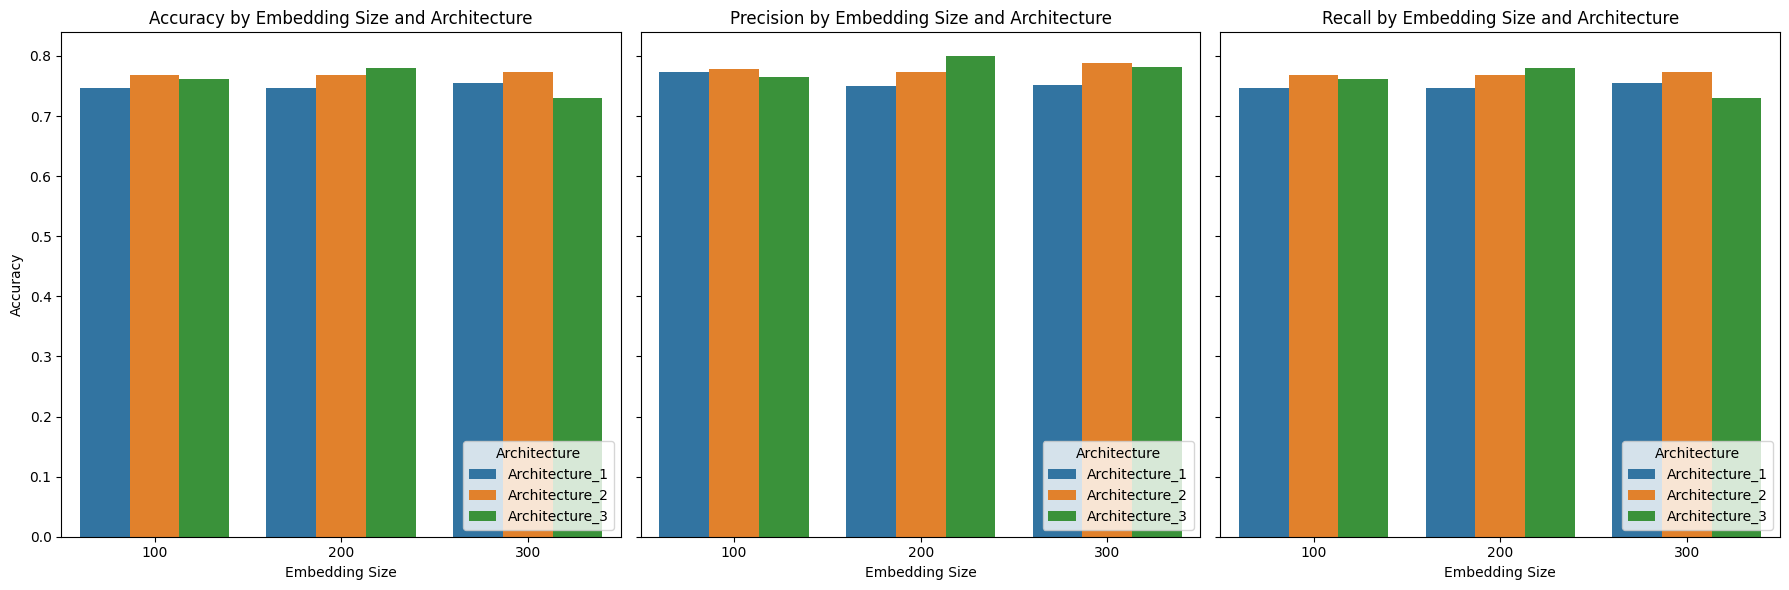

In [ ]:
metrics = ["Accuracy", "Precision", "Recall"]
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, metric in enumerate(metrics):
    sns.barplot(x="Embedding Size", y=metric, hue="Architecture", data=results_df, ax=axes[i])
    axes[i].set_title(f'{metric} by Embedding Size and Architecture')
    axes[i].set_xlabel('Embedding Size')
    axes[i].legend(title='Architecture', loc='lower right')

plt.tight_layout()
plt.show()

## Glove embeddings

Descargamos embeddings de GloVe con los mismos tamaños que los nuestros.

In [ ]:
import gensim.downloader

glove_wiki_gigaword_100 = gensim.downloader.load('glove-wiki-gigaword-100')
glove_wiki_gigaword_200 = gensim.downloader.load('glove-wiki-gigaword-200')
glove_wiki_gigaword_300 = gensim.downloader.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 128.1/128.1MB downloaded
[==================================================] 100.0% 252.1/252.1MB downloaded
[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
def create_glove_embedding_matrix(glove_model: Dict[str, np.ndarray], tokenizer: Tokenizer, embedding_size: int) -> np.ndarray:
    """
    Crea una matriz de embeddings usando un modelo GloVe preentrenado y un tokenizador de Keras.

    Args:
        glove_model (Dict[str, np.ndarray]): Diccionario del modelo GloVe donde las claves son palabras y los valores son vectores de embeddings.
        tokenizer (Tokenizer): Tokenizador de Keras ajustado en el corpus de datos.
        embedding_size (int): El tamaño de los vectores de embeddings (debe coincidir con el tamaño de los vectores GloVe).

    Returns:
        np.ndarray: Matriz de embeddings de tamaño (vocab_size, embedding_size), donde cada fila corresponde a un vector de embedding para una palabra.
    """
    # Tamaño del vocabulario basado en el tokenizador
    vocab_size = len(tokenizer.word_index) + 1

    # Inicializa la matriz de embeddings con ceros
    embedding_matrix = np.zeros((vocab_size, embedding_size))

    # Rellena la matriz de embeddings con los vectores de GloVe correspondientes a cada palabra en el vocabulario
    for word, idx in tokenizer.word_index.items():
        if word in glove_model:  # Verifica si la palabra está en el modelo GloVe
            embedding_matrix[idx] = glove_model[word]  # Asigna el vector GloVe a la posición correspondiente en la matriz

    return embedding_matrix

# Diccionario para almacenar los resultados de la evaluación de modelos con GloVe
results_glove = {
    "Architecture": [],  # Arquitectura del modelo
    "Embedding Size": [],  # Tamaño del embedding
    "Accuracy": [],  # Accuracy en el conjunto de prueba
    "Precision": [],  # Precision en el conjunto de prueba
    "Recall": []  # Recall en el conjunto de prueba
}

### Embeddings de tamaño 100

In [ ]:
embedding_size = 100
embedding_matrix = create_glove_embedding_matrix(glove_wiki_gigaword_100, tokenizer, embedding_size)

#### Arquitectura 1

In [ ]:
model = create_model_architecture_1(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ (None, 250, 100)            │         901,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 25000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 128)                 │       3,200,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,101,515 (15.65 MB)

 Trainable params: 3,200,515 (12.21 MB)

 Non-trainable params: 901,000 (3.44 MB)

In [ ]:
history = train_model(model, (X_train, y_train), (X_val, y_val))
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results_glove["Architecture"].append("Architecture_1")
results_glove["Embedding Size"].append(embedding_size)
results_glove["Accuracy"].append(accuracy)
results_glove["Precision"].append(precision)
results_glove["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.4568 - loss: 1.0517 - val_accuracy: 0.6618 - val_loss: 0.7729
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8693 - loss: 0.4351 - val_accuracy: 0.7018 - val_loss: 0.6868
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9673 - loss: 0.1561 - val_accuracy: 0.7055 - val_loss: 0.7494
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9953 - loss: 0.0686 - val_accuracy: 0.7164 - val_loss: 0.8066
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0315 - val_accuracy: 0.7345 - val_loss: 0.7880
Epoch 5: early stopping
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


#### Arquitectura 2

In [ ]:
model = create_model_architecture_2(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ (None, 250, 100)            │         901,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 25000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 256)                 │       6,400,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,334,539 (27.98 MB)

 Trainable params: 6,433,539 (24.54 MB)

 Non-trainable params: 901,000 (3.44 MB)

In [ ]:
history = train_model(model, (X_train, y_train), (X_val, y_val))
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results_glove["Architecture"].append("Architecture_2")
results_glove["Embedding Size"].append(embedding_size)
results_glove["Accuracy"].append(accuracy)
results_glove["Precision"].append(precision)
results_glove["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5509 - loss: 0.9265 - val_accuracy: 0.6945 - val_loss: 0.7253
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9258 - loss: 0.2258 - val_accuracy: 0.7055 - val_loss: 0.8071
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9913 - loss: 0.0455 - val_accuracy: 0.7491 - val_loss: 0.8563
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0067 - val_accuracy: 0.7164 - val_loss: 1.0226
Epoch 4: early stopping
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


#### Arquitectura 3

In [ ]:
model = create_model_architecture_3(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)             │ (None, 250, 100)            │         901,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 25000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 512)                 │      12,800,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,833,611 (52.77 MB)

 Trainable params: 12,932,611 (49.33 MB)

 Non-trainable params: 901,000 (3.44 MB)

In [ ]:
history = train_model(model, (X_train, y_train), (X_val, y_val))
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results_glove["Architecture"].append("Architecture_3")
results_glove["Embedding Size"].append(embedding_size)
results_glove["Accuracy"].append(accuracy)
results_glove["Precision"].append(precision)
results_glove["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.4843 - loss: 1.0707 - val_accuracy: 0.6182 - val_loss: 0.9509
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8939 - loss: 0.3028 - val_accuracy: 0.7455 - val_loss: 0.7710
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9919 - loss: 0.0509 - val_accuracy: 0.7455 - val_loss: 0.9706
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 0.7564 - val_loss: 1.1066
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.7491 - val_loss: 1.1134
Epoch 5: early stopping
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


### Embeddings de tamaño 200

In [ ]:
embedding_size = 200
embedding_matrix = create_glove_embedding_matrix(glove_wiki_gigaword_200, tokenizer, embedding_size)

#### Arquitectura 1

In [ ]:
model = create_model_architecture_1(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)             │ (None, 250, 200)            │       1,802,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 50000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 128)                 │       6,400,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,202,515 (31.29 MB)

 Trainable params: 6,400,515 (24.42 MB)

 Non-trainable params: 1,802,000 (6.87 MB)

In [ ]:
history = train_model(model, (X_train, y_train), (X_val, y_val))
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results_glove["Architecture"].append("Architecture_1")
results_glove["Embedding Size"].append(embedding_size)
results_glove["Accuracy"].append(accuracy)
results_glove["Precision"].append(precision)
results_glove["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5564 - loss: 0.9239 - val_accuracy: 0.7055 - val_loss: 0.6890
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9718 - loss: 0.1552 - val_accuracy: 0.7455 - val_loss: 0.7350
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9985 - loss: 0.0441 - val_accuracy: 0.7273 - val_loss: 0.7139
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0140 - val_accuracy: 0.7345 - val_loss: 0.7393
Epoch 4: early stopping
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


#### Arquitectura 2

In [ ]:
model = create_model_architecture_2(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)             │ (None, 250, 200)            │       1,802,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 50000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 256)                 │      12,800,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,635,539 (55.83 MB)

 Trainable params: 12,833,539 (48.96 MB)

 Non-trainable params: 1,802,000 (6.87 MB)

In [ ]:
history = train_model(model, (X_train, y_train), (X_val, y_val))
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results_glove["Architecture"].append("Architecture_2")
results_glove["Embedding Size"].append(embedding_size)
results_glove["Accuracy"].append(accuracy)
results_glove["Precision"].append(precision)
results_glove["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5592 - loss: 0.9067 - val_accuracy: 0.7273 - val_loss: 0.6684
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9782 - loss: 0.1288 - val_accuracy: 0.7055 - val_loss: 0.7825
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0163 - val_accuracy: 0.7455 - val_loss: 0.9360
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.7491 - val_loss: 0.9460
Epoch 4: early stopping
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


#### Arquitectura 3

In [ ]:
model = create_model_architecture_3(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)             │ (None, 250, 200)            │       1,802,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 50000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 512)                 │      25,600,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,534,611 (105.04 MB)

 Trainable params: 25,732,611 (98.16 MB)

 Non-trainable params: 1,802,000 (6.87 MB)

In [ ]:
history = train_model(model, (X_train, y_train), (X_val, y_val))
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results_glove["Architecture"].append("Architecture_3")
results_glove["Embedding Size"].append(embedding_size)
results_glove["Accuracy"].append(accuracy)
results_glove["Precision"].append(precision)
results_glove["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.5490 - loss: 0.9966 - val_accuracy: 0.7273 - val_loss: 0.6785
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9600 - loss: 0.1562 - val_accuracy: 0.7418 - val_loss: 0.9131
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9797 - loss: 0.0670 - val_accuracy: 0.7455 - val_loss: 0.9136
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9975 - loss: 0.0088 - val_accuracy: 0.7455 - val_loss: 1.0036
Epoch 4: early stopping
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


### Embeddings de tamaño 300

In [ ]:
embedding_size = 300
embedding_matrix = create_glove_embedding_matrix(glove_wiki_gigaword_300, tokenizer, embedding_size)

#### Arquitectura 1

In [ ]:
model = create_model_architecture_1(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)             │ (None, 250, 300)            │       2,703,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 75000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 128)                 │       9,600,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,303,515 (46.93 MB)

 Trainable params: 9,600,515 (36.62 MB)

 Non-trainable params: 2,703,000 (10.31 MB)

In [ ]:
history = train_model(model, (X_train, y_train), (X_val, y_val))
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results_glove["Architecture"].append("Architecture_1")
results_glove["Embedding Size"].append(embedding_size)
results_glove["Accuracy"].append(accuracy)
results_glove["Precision"].append(precision)
results_glove["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6242 - loss: 0.8409 - val_accuracy: 0.7236 - val_loss: 0.6927
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9850 - loss: 0.0826 - val_accuracy: 0.7455 - val_loss: 0.7222
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0087 - val_accuracy: 0.7600 - val_loss: 0.7359
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.7491 - val_loss: 0.7653
Epoch 4: early stopping
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


#### Arquitectura 2

In [ ]:
model = create_model_architecture_2(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)             │ (None, 250, 300)            │       2,703,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 75000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 256)                 │      19,200,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,936,539 (83.68 MB)

 Trainable params: 19,233,539 (73.37 MB)

 Non-trainable params: 2,703,000 (10.31 MB)

In [ ]:
history = train_model(model, (X_train, y_train), (X_val, y_val))
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results_glove["Architecture"].append("Architecture_2")
results_glove["Embedding Size"].append(embedding_size)
results_glove["Accuracy"].append(accuracy)
results_glove["Precision"].append(precision)
results_glove["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5946 - loss: 0.8623 - val_accuracy: 0.7455 - val_loss: 0.6367
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9977 - loss: 0.0573 - val_accuracy: 0.7673 - val_loss: 0.7822
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.7491 - val_loss: 0.9338
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 6.9845e-04 - val_accuracy: 0.7491 - val_loss: 0.9466
Epoch 4: early stopping
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


#### Arquitectura 3

In [ ]:
model = create_model_architecture_3(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)             │ (None, 250, 300)            │       2,703,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 75000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 512)                 │      38,400,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,235,611 (157.30 MB)

 Trainable params: 38,532,611 (146.99 MB)

 Non-trainable params: 2,703,000 (10.31 MB)

In [ ]:
history = train_model(model, (X_train, y_train), (X_val, y_val))
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results_glove["Architecture"].append("Architecture_3")
results_glove["Embedding Size"].append(embedding_size)
results_glove["Accuracy"].append(accuracy)
results_glove["Precision"].append(precision)
results_glove["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5807 - loss: 0.9482 - val_accuracy: 0.7236 - val_loss: 0.6959
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9861 - loss: 0.0863 - val_accuracy: 0.7382 - val_loss: 0.8463
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9773 - loss: 0.0487 - val_accuracy: 0.7309 - val_loss: 1.0173
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9983 - loss: 0.0080 - val_accuracy: 0.7236 - val_loss: 1.0341
Epoch 4: early stopping
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


#### Resultados

In [ ]:
glove_results_df = pd.DataFrame(results_glove)
glove_results_df

,Architecture,Embedding Size,Accuracy,Precision,Recall
0,Architecture_1,100,0.722022,0.716897,0.722022
1,Architecture_2,100,0.693141,0.684292,0.693141
2,Architecture_3,100,0.693141,0.687421,0.693141
3,Architecture_1,200,0.707581,0.702727,0.707581
4,Architecture_2,200,0.707581,0.699908,0.707581
5,Architecture_3,200,0.682310,0.675808,0.682310
6,Architecture_1,300,0.732852,0.726632,0.732852
7,Architecture_2,300,0.761733,0.759259,0.761733
8,Architecture_3,300,0.703971,0.712965,0.703971


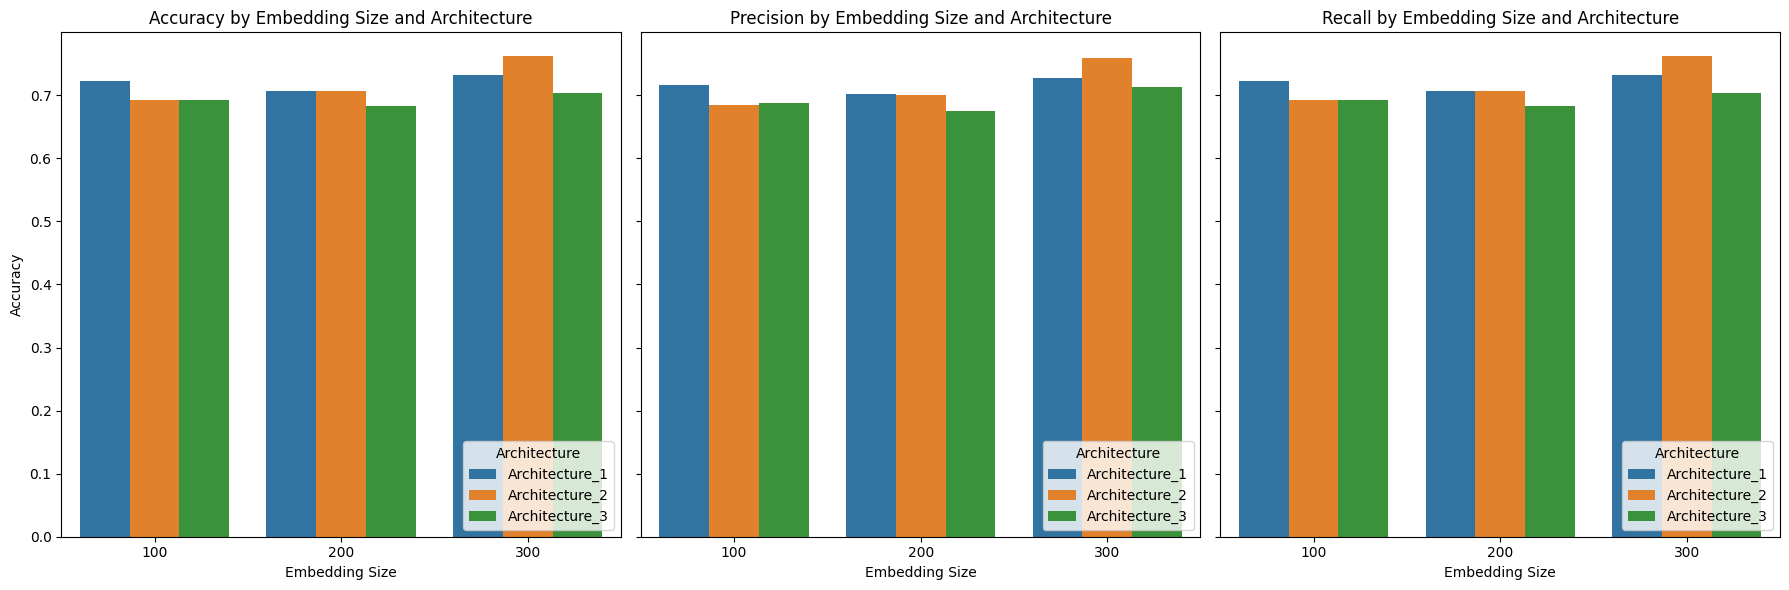

In [ ]:
metrics = ["Accuracy", "Precision", "Recall"]
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, metric in enumerate(metrics):
    sns.barplot(x="Embedding Size", y=metric, hue="Architecture", data=glove_results_df, ax=axes[i])
    axes[i].set_title(f'{metric} by Embedding Size and Architecture')
    axes[i].set_xlabel('Embedding Size')
    axes[i].legend(title='Architecture', loc='lower right')

plt.tight_layout()
plt.show()